## Project scope

**Question:** Is higher basic hygiene coverage associated with lower child mortality across countries?

**Data:** OWID country-year data (2000–2020), cross-section in 2015; time series for Bangladesh, Angola and auto-pick a high-coverage country.

## Key findings

- In 2015, basic hygiene coverage and child mortality showed a **strong negative association** across countries (**Pearson r = -0.76**, **n = 104** countries).
- The 2015 scatter plot suggests that countries with **higher basic hygiene coverage** tend to have **lower child mortality rates**.
- In the 2000–2020 time series, **Bangladesh** shows a clear increase in basic hygiene coverage alongside a decline in child mortality.
- **Angola** remains with lower hygiene coverage and higher child mortality compared to **Armenia**, which has higher coverage and consistently low mortality.


Files in Colab: ['.config', 'hygiene.csv.csv', 'figures', 'child-mortality.csv.csv', 'data', '.ipynb_checkpoints', 'sample_data']

Hygiene % summary (should be ~0-100):
count    1363.000000
mean       52.782271
std        33.036299
min         0.000000
25%        20.615326
50%        54.316251
75%        85.099869
max       112.401688
Name: basic_hygiene_coverage_pct, dtype: float64

Merged shape: (1322, 4)
       country  year  basic_hygiene_coverage_pct  child_mortality_rate
0  Afghanistan  2005                   36.280521                 10.97
1  Afghanistan  2006                   36.380010                 10.51
2  Afghanistan  2007                   36.427039                 10.07
3  Afghanistan  2008                   36.443403                  9.63
4  Afghanistan  2009                   36.496165                  9.22

Countries in 2015: 104
Pearson correlation (2015): -0.76

Selected COUNTRIES for time series: ['Bangladesh', 'Angola', 'Armenia']


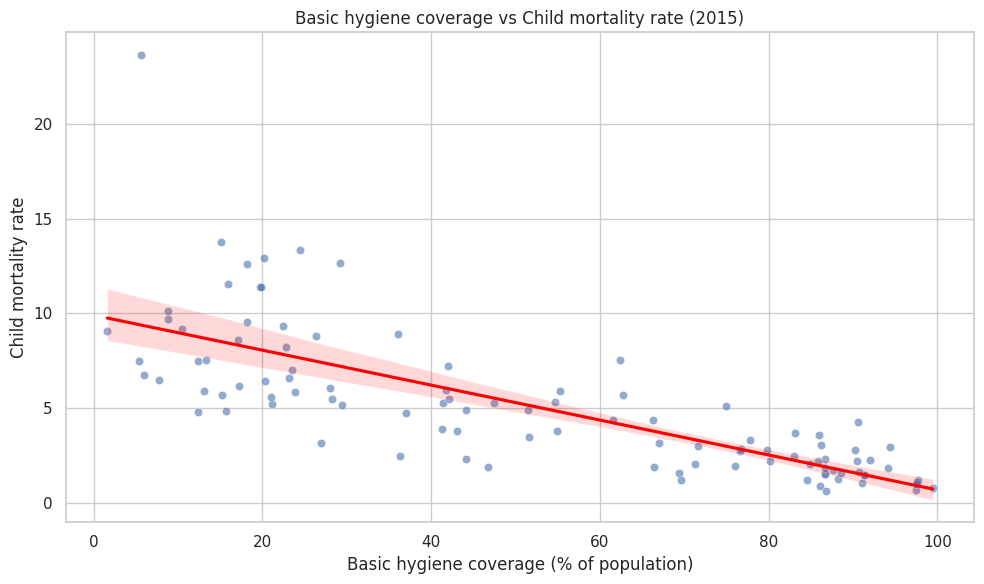

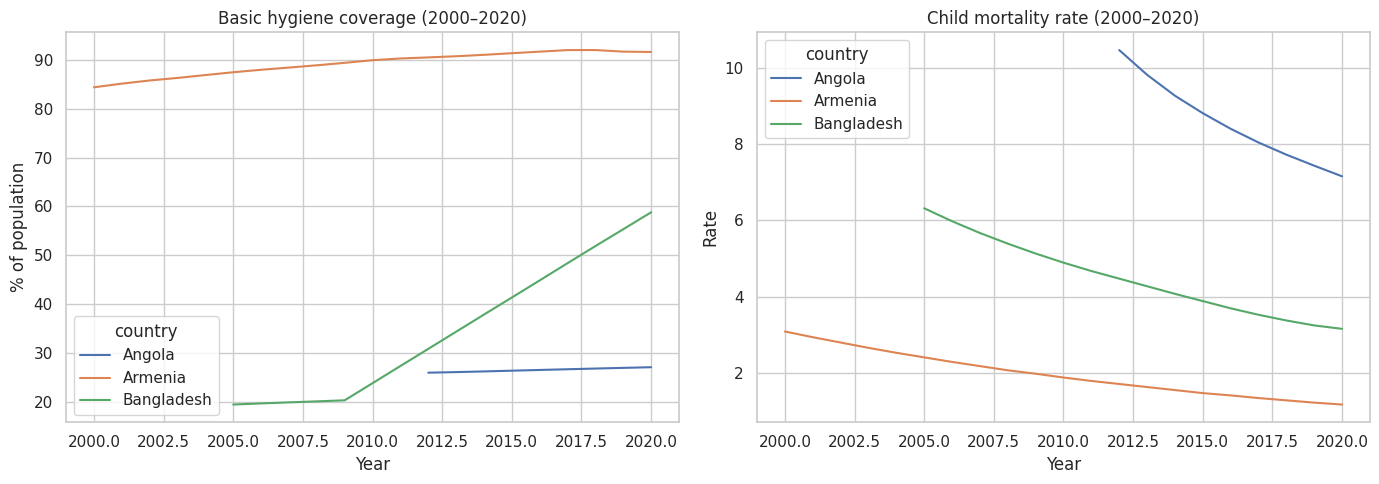


Saved:
- data/merged_hygiene_child_mortality_2000_2020.csv
- figures/scatter_hygiene_child_mortality_2015.png
- figures/timeseries_selected_countries.png


In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

START_YEAR = 2000
END_YEAR = 2020
FOCUS_YEAR = 2015

WASH_PATH = "hygiene.csv.csv"
HEALTH_PATH = "child-mortality.csv.csv"

WASH_VALUE_COL = "hyg_bas_pop__residence_total"
HEALTH_VALUE_COL = "Child mortality rate"


# Load data
print("Files in Colab:", os.listdir())

df_wash_raw = pd.read_csv(WASH_PATH)
df_health_raw = pd.read_csv(HEALTH_PATH)

# Keep only what I need + rename
df_wash = df_wash_raw[["Entity", "Year", WASH_VALUE_COL]].copy()
df_wash.columns = ["country", "year", "basic_hygiene_people"]

df_health = df_health_raw[["Entity", "Year", HEALTH_VALUE_COL]].copy()
df_health.columns = ["country", "year", "child_mortality_rate"]

# Filter years
df_wash = df_wash[(df_wash["year"] >= START_YEAR) & (df_wash["year"] <= END_YEAR)].copy()
df_health = df_health[(df_health["year"] >= START_YEAR) & (df_health["year"] <= END_YEAR)].copy()

# Ensure numeric
df_wash["basic_hygiene_people"] = pd.to_numeric(df_wash["basic_hygiene_people"], errors="coerce")
df_health["child_mortality_rate"] = pd.to_numeric(df_health["child_mortality_rate"], errors="coerce")


# Load population and convert people to %
pop_url = "https://ourworldindata.org/grapher/population.csv"
df_pop_raw = pd.read_csv(pop_url)

df_pop = df_pop_raw.rename(columns={"Entity": "country", "Year": "year"}).copy()
pop_value_col = [c for c in df_pop.columns if c not in ["country", "year", "Code"]][0]
df_pop = df_pop[["country", "year", pop_value_col]].rename(columns={pop_value_col: "population"})

df_pop["population"] = pd.to_numeric(df_pop["population"], errors="coerce")

# Merge population into wash and compute percentage
df_wash = df_wash.merge(df_pop, on=["country", "year"], how="left")
df_wash["basic_hygiene_coverage_pct"] = (df_wash["basic_hygiene_people"] / df_wash["population"]) * 100

# Quick check (should be roughly 0–100)
print("\nHygiene % summary (should be ~0-100):")
print(df_wash["basic_hygiene_coverage_pct"].describe())


# Merge (final dataset)
df_merged = pd.merge(
    df_wash[["country", "year", "basic_hygiene_coverage_pct"]],
    df_health,
    on=["country", "year"],
    how="inner"
).dropna()

# Keep valid ranges
df_merged = df_merged[(df_merged["basic_hygiene_coverage_pct"] >= 0) & (df_merged["basic_hygiene_coverage_pct"] <= 100)]
df_merged = df_merged[df_merged["child_mortality_rate"] >= 0]

print("\nMerged shape:", df_merged.shape)
print(df_merged.head())


# Correlation (2015)
df_2015 = df_merged[df_merged["year"] == FOCUS_YEAR].copy()
corr = df_2015["basic_hygiene_coverage_pct"].corr(df_2015["child_mortality_rate"])

print("\nCountries in 2015:", df_2015["country"].nunique())
print("Pearson correlation (2015):", round(corr, 3))


# I chose 2–3 countries for time series
# Bangladesh + Angola + (auto-pick a high-coverage country with full data)
years_needed = END_YEAR - START_YEAR + 1
year_counts = df_merged.groupby("country")["year"].nunique().sort_values(ascending=False)
complete_countries = year_counts[year_counts >= years_needed].index

df_candidates_2015 = df_merged[
    (df_merged["year"] == FOCUS_YEAR) &
    (df_merged["country"].isin(complete_countries))
].copy()

default_countries = ["Bangladesh", "Angola"]

high_country = None
if not df_candidates_2015.empty:
    ranked = df_candidates_2015.sort_values("basic_hygiene_coverage_pct", ascending=False)
    ranked = ranked[~ranked["country"].isin(default_countries)]
    if not ranked.empty:
        high_country = ranked.iloc[0]["country"]

COUNTRIES = default_countries + ([high_country] if high_country else [])
print("\nSelected COUNTRIES for time series:", COUNTRIES)


# Plot 1 — Scatter (2015)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_2015, x="basic_hygiene_coverage_pct", y="child_mortality_rate", alpha=0.6)
sns.regplot(data=df_2015, x="basic_hygiene_coverage_pct", y="child_mortality_rate", scatter=False, color="red")
plt.title(f"Basic hygiene coverage vs Child mortality rate ({FOCUS_YEAR})")
plt.xlabel("Basic hygiene coverage (% of population)")
plt.ylabel("Child mortality rate")
plt.tight_layout()
plt.show()


# Plot 2 — Time series (selected countries)
df_sel = df_merged[df_merged["country"].isin(COUNTRIES)].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(data=df_sel, x="year", y="basic_hygiene_coverage_pct", hue="country", ax=axes[0])
axes[0].set_title("Basic hygiene coverage (2000–2020)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("% of population")

sns.lineplot(data=df_sel, x="year", y="child_mortality_rate", hue="country", ax=axes[1])
axes[1].set_title("Child mortality rate (2000–2020)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Rate")

plt.tight_layout()
plt.show()


# Save outputs (CSV + figures)
os.makedirs("data", exist_ok=True)
os.makedirs("figures", exist_ok=True)

df_merged.to_csv("data/merged_hygiene_child_mortality_2000_2020.csv", index=False)

# Save scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_2015, x="basic_hygiene_coverage_pct", y="child_mortality_rate", alpha=0.6)
sns.regplot(data=df_2015, x="basic_hygiene_coverage_pct", y="child_mortality_rate", scatter=False, color="red")
plt.title(f"Basic hygiene coverage vs Child mortality rate ({FOCUS_YEAR})")
plt.xlabel("Basic hygiene coverage (% of population)")
plt.ylabel("Child mortality rate")
plt.tight_layout()
plt.savefig("figures/scatter_hygiene_child_mortality_2015.png", dpi=200)
plt.close()

# Save time series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.lineplot(data=df_sel, x="year", y="basic_hygiene_coverage_pct", hue="country", ax=axes[0])
axes[0].set_title("Basic hygiene coverage (2000–2020)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("% of population")

sns.lineplot(data=df_sel, x="year", y="child_mortality_rate", hue="country", ax=axes[1])
axes[1].set_title("Child mortality rate (2000–2020)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Rate")

plt.tight_layout()
plt.savefig("figures/timeseries_selected_countries.png", dpi=200)
plt.close()

print("\nSaved:")
print("- data/merged_hygiene_child_mortality_2000_2020.csv")
print("- figures/scatter_hygiene_child_mortality_2015.png")
print("- figures/timeseries_selected_countries.png")




In [26]:
corr_2015 = df_2015["basic_hygiene_coverage_pct"].corr(df_2015["child_mortality_rate"])
n_countries_2015 = df_2015["country"].nunique()
print("Countries in 2015:", n_countries_2015)
print("Pearson correlation (2015):", round(corr_2015, 3))
print("Selected countries:", COUNTRIES)


Countries in 2015: 104
Pearson correlation (2015): -0.76
Selected countries: ['Bangladesh', 'Angola', 'Armenia']


In [27]:
!zip -r mini_project.zip data figures


  adding: data/ (stored 0%)
  adding: data/merged_hygiene_child_mortality_2000_2020.csv (deflated 60%)
  adding: figures/ (stored 0%)
  adding: figures/timeseries_selected_countries.png (deflated 13%)
  adding: figures/scatter_hygiene_child_mortality_2015.png (deflated 15%)
